# Assignment 1

Due Friday 5th August 23:59

## Assignment Outline

### Explore data
* Inspect the shape and types of data
* Visualization
* Value counts
### Clean data
* null
* nonsensical 
### Understand data
* Find relationships
    * Correlation
    * Mean house price against categorical levels
* Feature engineering
    * livingArea and bedrooms variable?
    * lotSize and landValue variable?


In [180]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Import CSV

In [181]:
import csv

with open("data.csv", 'r') as data:
    header = csv.reader(data).__next__()

# remove unnamed row.
houses = pd.read_csv('data.csv', usecols=header[1:])

## Splitting the data

In [182]:
from sklearn.model_selection import train_test_split
X = houses.drop(["price"], axis = 1) # indepedent features
y = houses["price"].copy          # dependent variable

train_set, test_set = train_test_split(houses, test_size=0.2, random_state=0)


In [183]:
train_set.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1649,153000,0.11,16,2900,1480,40,2,0,2.5,4,hot air,gas,public/commercial,No,No,No
1465,223000,0.33,18,27000,1360,40,3,1,1.5,8,electric,electric,public/commercial,No,No,No
361,178500,1.00,12,32000,1952,71,3,2,2.0,9,hot air,oil,septic,No,No,No
315,168500,0.44,34,31800,1586,64,3,1,1.5,7,hot air,gas,public/commercial,No,No,No
1372,167500,0.16,18,15100,1492,40,3,0,2.5,6,electric,electric,public/commercial,No,No,No


In [184]:
test_set.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1318,229900,0.44,7,24200,1328,64,3,1,2.5,8,hot air,gas,public/commercial,No,No,No
124,158000,0.52,0,4400,2098,44,3,0,2.0,7,hot air,gas,septic,No,Yes,Yes
648,367500,0.27,2,78200,2205,57,3,1,2.5,10,hot air,gas,public/commercial,No,No,Yes
249,128850,0.92,16,5500,824,45,3,0,1.5,5,electric,electric,septic,No,No,No
1599,290000,0.61,34,32300,2728,64,4,1,2.5,10,hot water/steam,gas,public/commercial,No,No,No


## Explore the Training Set

There are 1105 rows and 16 features of the training set. There are no missing values.

In [185]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382 entries, 1649 to 684
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            1382 non-null   int64  
 1   lotSize          1382 non-null   float64
 2   age              1382 non-null   int64  
 3   landValue        1382 non-null   int64  
 4   livingArea       1382 non-null   int64  
 5   pctCollege       1382 non-null   int64  
 6   bedrooms         1382 non-null   int64  
 7   fireplaces       1382 non-null   int64  
 8   bathrooms        1382 non-null   float64
 9   rooms            1382 non-null   int64  
 10  heating          1382 non-null   object 
 11  fuel             1382 non-null   object 
 12  sewer            1382 non-null   object 
 13  waterfront       1382 non-null   object 
 14  newConstruction  1382 non-null   object 
 15  centralAir       1382 non-null   object 
dtypes: float64(2), int64(8), object(6)
memory usage: 183.5+ KB

livingArea[5], pctCollege[6], bedrooms[7], fireplaces[8], bathrooms[9] and rooms[10] are approximately normally distributed.
Price[1], lotSize[2], age[3], landValue[4] are right skewed and could use normalizing.

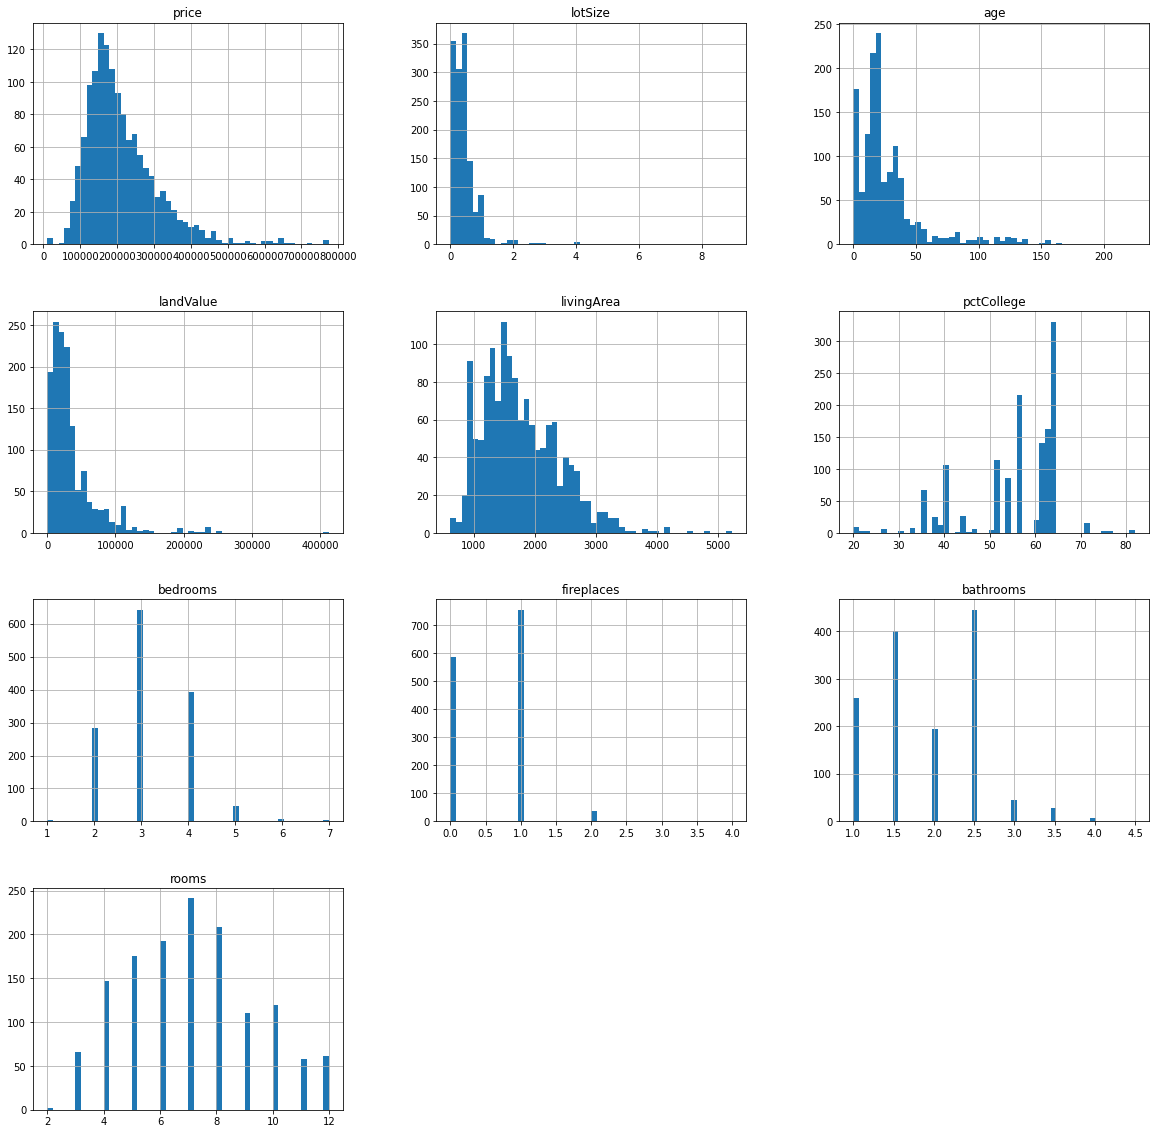

In [186]:
train_set.hist(bins = 50, figsize = (20,20))
fig = plt.gcf() 
fig.savefig('hist.pdf', bbox_inches = 'tight')

Below emphasises the right tail skew in features 1, 2, 3 and 4. They all have a disproportionately large spread and very large values.


In [187]:
train_set.describe()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,211977.407381,0.495904,27.996382,35266.005789,1758.619392,55.685962,3.164978,0.610709,1.904848,7.049204
std,99608.842830,0.661244,29.182973,36616.276086,625.841288,10.316558,0.834791,0.564815,0.661465,2.330519
min,10300.000000,0.000000,0.000000,300.000000,616.000000,20.000000,1.000000,0.000000,1.000000,2.000000
25%,145000.000000,0.170000,13.000000,15100.000000,1297.000000,52.000000,3.000000,0.000000,1.500000,5.000000
50%,188900.000000,0.370000,19.000000,25100.000000,1643.000000,57.000000,3.000000,1.000000,2.000000,7.000000
75%,259106.500000,0.540000,34.000000,40875.000000,2179.000000,64.000000,4.000000,1.000000,2.500000,9.000000
max,775000.000000,8.970000,225.000000,412600.000000,5228.000000,82.000000,7.000000,4.000000,4.500000,12.000000


livingArea is correlated with multiple other features which may have a negative affect on our model. Bedrooms and rooms may also affect our model negatively. I would like to see how the model performs both with and without these features.

<AxesSubplot:>

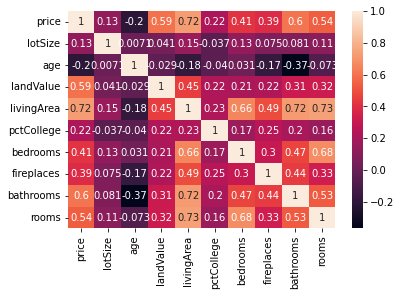

In [188]:
sns.heatmap(train_set.corr(), annot=True)

It may be useful to see how the frequency of the categorical levels compare.

In [189]:
from sklearn.compose import make_column_selector as selector

my_selector = selector(dtype_include=object)
categorical = my_selector(train_set)

# print the levels of the categorical variables
def levels(df, features):
    [print(feature, df[feature].unique()) for feature in features]

levels(train_set, categorical)


heating ['hot air' 'electric' 'hot water/steam']
fuel ['gas' 'electric' 'oil']
sewer ['public/commercial' 'septic' 'none']
waterfront ['No' 'Yes']
newConstruction ['No' 'Yes']
centralAir ['No' 'Yes']


Barcharts are created to see how these levels balance.

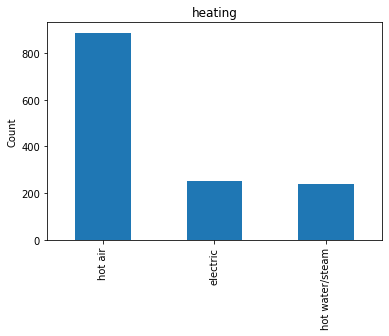

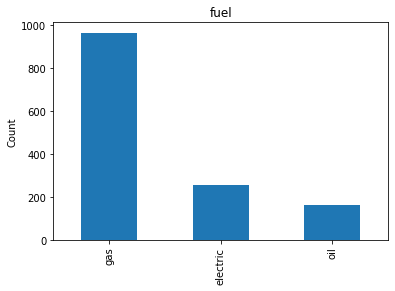

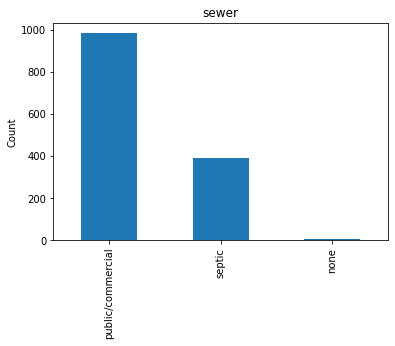

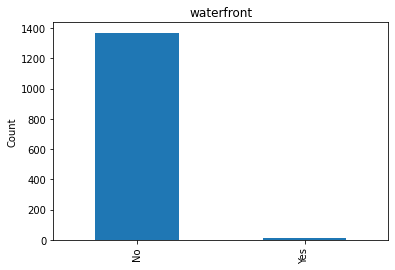

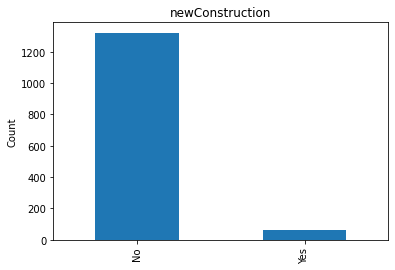

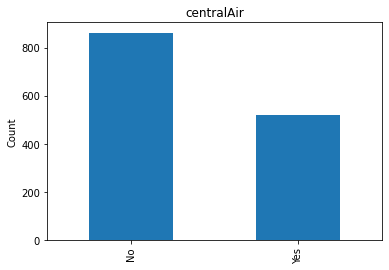

In [190]:
def plot_categorical(df, features):
    for feature in features:
        df[feature].value_counts().plot(kind='bar')
        plt.title(feature)
        plt.ylabel('Count')
        plt.show()
plot_categorical(train_set, categorical)

Compare categorical levels with their mean price

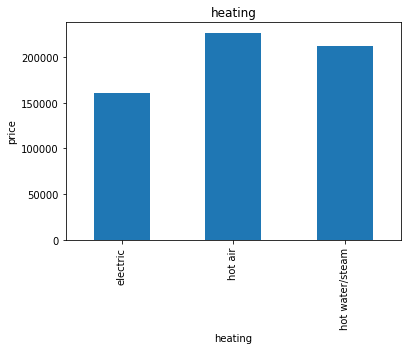

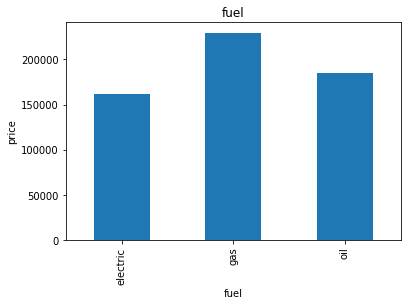

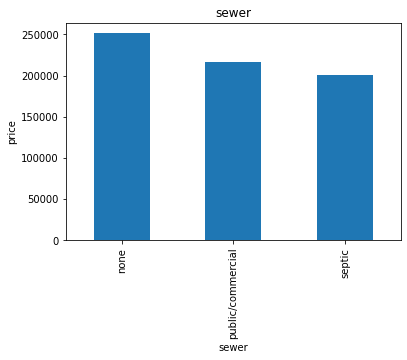

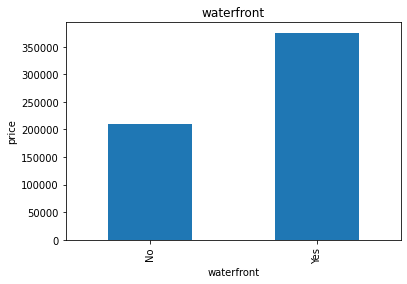

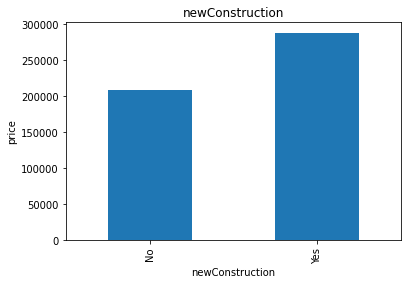

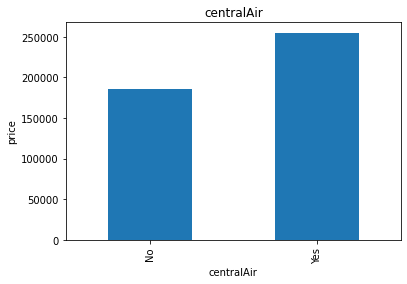

In [191]:
def compare_categorical(df, features, target):
    for feature in features:
        df.groupby(feature).mean()[target].plot(kind='bar')
        plt.title(feature)
        plt.ylabel(target)
        plt.show()
compare_categorical(train_set, categorical, 'price')


In [192]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train_set, 
                                       test_size = 0.2,
                                      random_state = 0)

In [193]:
train_set.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
1442,170000,0.16,18,15100,1514,40,3,1,1.5,5,electric,electric,public/commercial,No,No,No
237,65000,0.16,19,15700,988,52,2,0,2.0,4,hot air,gas,public/commercial,No,No,No
234,120000,0.16,18,15100,1184,52,3,0,2.0,5,electric,electric,public/commercial,No,No,No
93,126900,0.46,26,18700,1350,51,3,0,1.5,5,hot air,gas,septic,No,No,No
1398,148000,0.41,84,18200,1182,64,3,1,1.5,8,hot air,oil,public/commercial,No,No,No


In [194]:
test_set.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
346,180000,0.41,17,25400,2228,64,3,1,2.5,7,hot water/steam,gas,public/commercial,No,No,No
468,242000,1.27,27,34200,1854,60,3,1,1.5,8,hot water/steam,oil,septic,No,No,No
196,150000,0.29,93,9200,1046,57,3,0,1.0,6,electric,electric,septic,No,No,No
79,145000,2.12,32,19000,1440,52,3,1,1.0,8,hot air,oil,septic,No,No,No
993,125500,0.06,19,16400,1479,63,3,1,1.5,5,hot air,gas,public/commercial,No,No,Yes


## Discover and visualize data

In [195]:
houses = train_set.copy()

In [196]:
corr_matrix = houses.corr()
corr_matrix["price"].sort_values(ascending = False)

price         1.000000
livingArea    0.733106
bathrooms     0.595455
landValue     0.571782
rooms         0.546706
fireplaces    0.424214
bedrooms      0.417820
pctCollege    0.200709
lotSize       0.125603
age          -0.182177
Name: price, dtype: float64

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

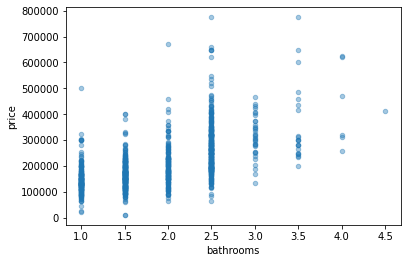

In [197]:
houses.plot(kind = "scatter", x = "bathrooms", y = "price",
           alpha = 0.4)

<AxesSubplot:xlabel='landValue', ylabel='livingArea'>

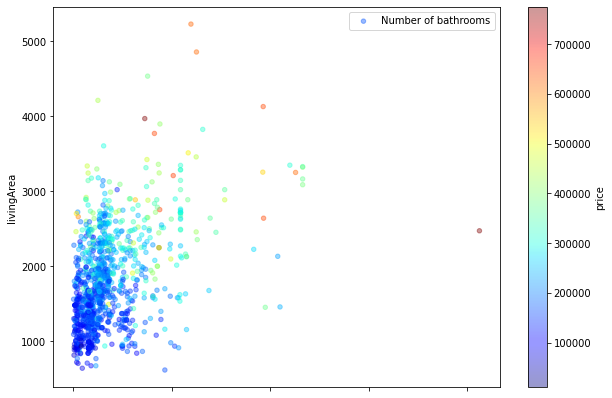

In [198]:
houses.plot(kind = "scatter", x = "landValue", y = "livingArea",
           alpha = 0.4,
           label = "Number of bathrooms",
           figsize = (10,7),
           c = "price", 
           cmap = plt.get_cmap("jet"))

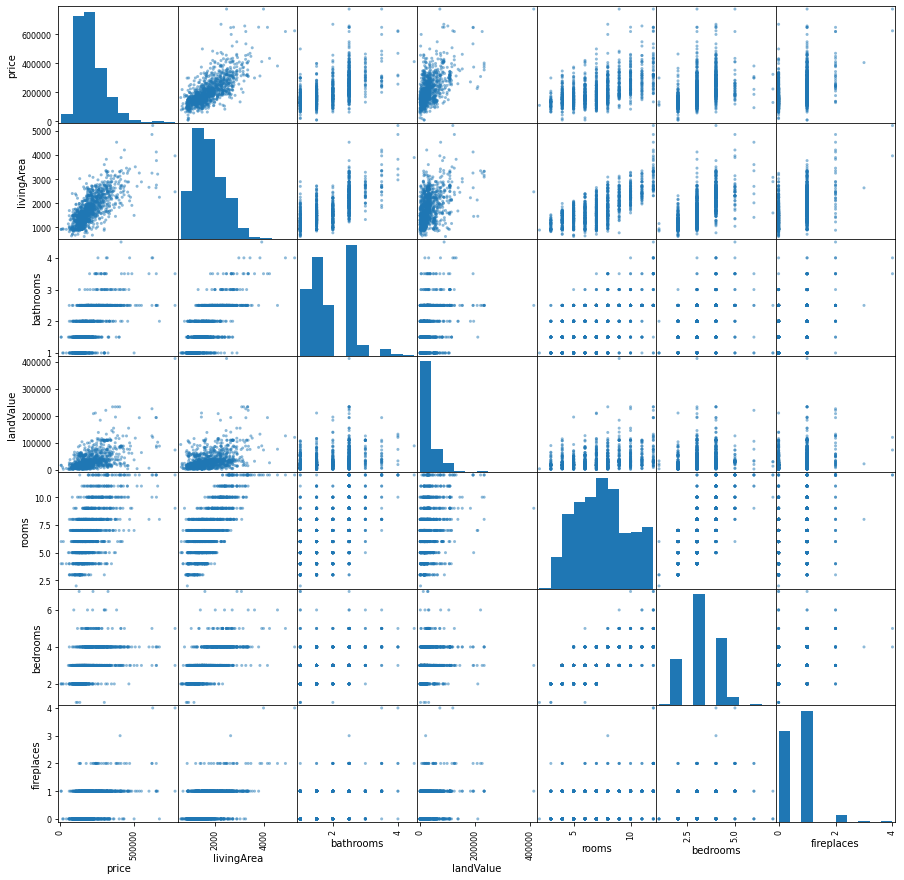

In [199]:
from pandas.plotting import scatter_matrix

attributes = ["price", "livingArea", "bathrooms", 
              "landValue", "rooms", "bedrooms", 
              "fireplaces"]
scatter_matrix(houses[attributes], figsize = (15,15))
plt.show()

## Pipeline

#### Split data

Separate the predictors and the labels since we don't
necessarily want to apply the same transformations
to the predictors and the target values.

In [228]:
X_train = train_set.drop("price", axis=1) # drop labels for training set
y_train = train_set["price"].copy()
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()

#### Transform Data

Now, we import necessary modules for data transformation

In [229]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Get all numerical data

In [230]:
# splits the data into categorical and numerical features
def split_columns(df):
      my_selector = selector(dtype_include=int)
      numerical_int = my_selector(df)
      my_selector = selector(dtype_include=float)
      numerical_float = my_selector(df)
      my_selector = selector(dtype_include=object)
      categorical = my_selector(df)
      return numerical_int, numerical_float, categorical

numerical_int, numerical_float, nominal = split_columns(X_train)
print("Features length:", len(X_train.columns), "\nCollected data: ",
      len(numerical_int) + len(nominal) + len(numerical_float))
numerical = numerical_int + numerical_float
print("Numerical: ", len(numerical))
print("Nominal:",len(nominal))


Features length: 15 
Collected data:  15
Numerical:  9
Nominal: 6


We have all the data separated into their corresponding groups. Note that all of our categorical variables are nominal, so we do not need an ordinal pipeline.

In [231]:
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', StandardScaler())])
# one hot encoder to convert nominal data into binary data.
nominal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('encoder', OneHotEncoder(handle_unknown='ignore'))])


Create the column transformer to allow our models to work with our categorical data and better perform with all of our features.

In [232]:
preprocessor = ColumnTransformer([
    ('numerical_transformer', numerical_pipeline, numerical),
    ('nominal_transformer', nominal_pipeline, nominal)
])

Since this is a regression problem, we'll need some relevant imports

In [233]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

Transform our data into all numerical, perform scaling and fill in missing values. Afterward fit the training data to a linear regression model.

In [237]:
# transform columns and fit the model
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'landValue',
                                                   'livingArea', 'pctCollege',
                                                   'bedrooms', 'fireplaces',
                                                   'rooms', 'lotSize',
                                                   'bathrooms']),
                                                 ('nominal_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['heating', 'fuel', 'sewer',
                                                   'waterfront',
                                                   'newConstruction',
                                                   'centralAir'])])),
                ('regressor', LinearRegression())])

## Make Predictions & Evaluate

#### Predict

Use our linear regression model from our training data to make predictions. Use RMSE to evaluate the model.

In [245]:
def evaluate_model(y, y_predict):
        print("RMSE on the training set: %.4f" % 
              np.sqrt(mean_squared_error(y, y_predict)))

In [246]:
y_train_predicted = lr_model.predict(X_train)
evaluate_model(y_train, y_train_predicted)

RMSE on the training set: 57247.5993


Check relative accuracy

In [248]:
def summarize_results(y_train, y_train_predict):
    return pd.DataFrame({'Actual': y_train, 'Predicted': y_train_predict,
                        'Difference': abs(y_train - y_train_predict),
                        'Difference_percent': (abs(y_train - y_train_predict)/y_train*100)})
results = summarize_results(y_train, y_train_predicted)
print((results['Difference_percent'].mean()))
results.sample(5)

23.28646094283461


,Actual,Predicted,Difference,Difference_percent
362,415000,427725.440553,12725.440553,3.066371
1261,399900,221811.513971,178088.486029,44.533255
815,159000,171993.764615,12993.764615,8.172179
286,187900,272815.893662,84915.893662,45.192067
523,303000,242340.490608,60659.509392,20.019640


Visualize how it's predicting.

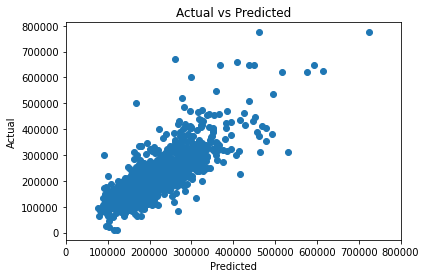

In [249]:
def graph_performance(y_train, y_train_predict):
    plt.scatter(y_train_predict, y_train)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Actual vs Predicted')
    plt.xlim(0,800000) # get x and y on the same scale
    plt.show()

graph_performance(y_train, y_train_predicted)

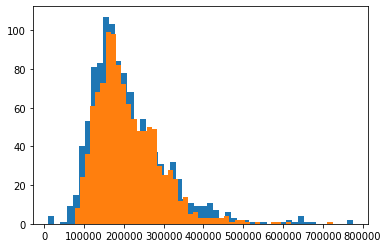

In [251]:
def results_hist(y_train, y_train_predict):
    plt.hist(y_train, bins=50)
    plt.hist(y_train_predict, bins=50)
    plt.show()
results_hist(y_train, y_train_predicted)


Check Predictions against test data

In [261]:
y_test_predicted = lr_model.predict(X_test)
evaluate_model(y_test, y_test_predicted)
summarize_results(y_test, y_test_predicted)


RMSE on the training set: 61496.0626


,Actual,Predicted,Difference,Difference_percent
346,180000,241456.466912,61456.466912,34.142482
468,242000,203396.662822,38603.337178,15.951792
196,150000,97980.056040,52019.943960,34.679963
79,145000,169937.864926,24937.864926,17.198528
993,125500,171714.661999,46214.661999,36.824432
...,...,...,...,...
1672,285000,236922.744623,48077.255377,16.869212
1700,255000,242848.676180,12151.323820,4.765225
1622,314230,299900.780524,14329.219476,4.560105
1553,171500,157498.569876,14001.430124,8.164099


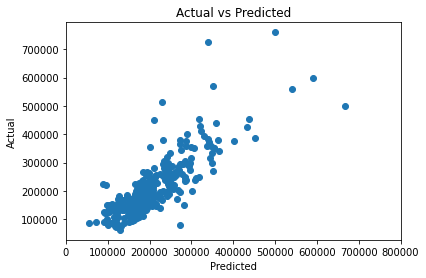

In [262]:
graph_performance(y_test, y_test_predicted)

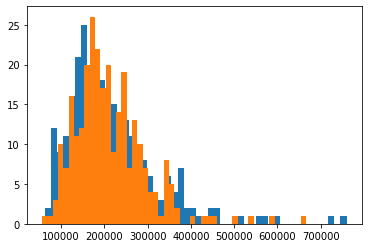

In [264]:
results_hist(y_test, y_test_predicted)

#### Cross Validation

Estimate the expected level of fit of the model using cross validation.

In [ ]:
cv_results = cross_validate(lr_model, X_train, y_train, 
                            scoring = 'neg_mean_squared_error', cv = 5)
scores = np.sqrt(-cv_results["test_score"])
print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")

The mean cross-validation RMSE is:  76299.7185 +/- 8127.3427


#### Support Vector Regressor

Fit our data to a support vector regressor to make predictions. Use RMSE again to evaluate, then cross validate and see how it compares to linear regression.

In [ ]:
def fit_predict_evaluate(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    print("RMSE on the training set: %.4f" % np.sqrt(mean_squared_error(y_train, y_train_predict)))
    cv_results = cross_validate(model, X_train, y_train, 
                                scoring = 'neg_mean_squared_error', cv = 5)
    scores = np.sqrt(-cv_results["test_score"])
    print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")
    
fit_predict_evaluate(lr_model, X_train, y_train)

RMSE on the training set: 74935.8563
The mean cross-validation RMSE is:  76299.7185 +/- 8127.3427


In [ ]:
from sklearn.svm import SVR
svm_model = Pipeline([
 ('preprocessor', preprocessor),
 ('regressor', SVR())
])
svm_model.fit(X_train, y_train);
y_train_predicted = svm_model.predict(X_train)
print("RMSE on the training set: %.4f" % np.sqrt(mean_squared_error(y_train, y_train_predicted)))
cv_results = cross_validate(svm_model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores = np.sqrt(-cv_results["test_score"])
print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")


RMSE on the training set: 100368.0646
The mean cross-validation RMSE is:  99724.6104 +/- 10705.4419


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'regressor__C': [1000, 10000, 100000, 1000000],
 'regressor__gamma': [0.1, 1, 10, 'scale', 'auto']},
]
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train);



In [ ]:
grid_search.best_params_

{'regressor__C': 100000, 'regressor__gamma': 'auto'}

In [ ]:
y_train_predicted = grid_search.best_estimator_.predict(X_train)
print("RMSE on the training set: %.4f" % np.sqrt(mean_squared_error(y_train, y_train_predicted)))


RMSE on the training set: 72769.5622


In [ ]:
cv_results = cross_validate(grid_search.best_estimator_, X_train, y_train,
                            scoring='neg_mean_squared_error', cv=5)
scores = np.sqrt(-cv_results["test_score"])
print("The mean cross-validation RMSE is: ", f"{scores.mean():.4f} +/- {scores.std():.4f}")

The mean cross-validation RMSE is:  74914.4852 +/- 8621.3739


In [ ]:
y_test_predicted = lr_model.predict(X_test)
print("RMSE of the LinearRegression model on the test set: %.4f" % 
      np.sqrt(mean_squared_error(y_test, y_test_predicted)))

RMSE of the LinearRegression model on the test set: 78330.4257


In [ ]:
y_test_predicted = svm_model.predict(X_test)
print("RMSE of the SVR model on the test set: %.4f" % 
      np.sqrt(mean_squared_error(y_test, y_test_predicted)))


RMSE of the SVR model on the test set: 110195.0551


In [ ]:
y_test_predicted = grid_search.best_estimator_.predict(X_test)
print("RMSE of the optimized SVR model on the test set: %.4f" % 
      np.sqrt(mean_squared_error(y_test, y_test_predicted)))

RMSE of the optimized SVR model on the test set: 77128.6047
